In [1]:
import warnings
import pandas as pd
import numpy as np
warnings.filterwarnings('ignore')

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import env

# Using saas.csv or log data from API usage or store_item_sales

In [2]:
# Importing saas.csv to a Data Frame
df = pd.read_csv('saas.csv')

In [3]:
# Checking Values to make sure import worked out correctly
df.head(3)

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0


In [4]:
# Taking a look at the columns and Data Types and Non-Null Count
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


# Split data (train/validate/test) and resample by any period, except daily, and aggregate using the sum.

#### Converting Month_Invoiced to 'datetime64' Data Type

In [5]:
# Converting sale_date type object to datetime64
df.Month_Invoiced = pd.to_datetime(df.Month_Invoiced)

#### Need to set the axis as Date

In [6]:
# Making the index equal to the Month_Invoiced
df = df.set_index('Month_Invoiced').sort_index()

In [7]:
# Checking date is sorted correctly
df.head(3)

,Customer_Id,Invoice_Id,Subscription_Type,Amount
Month_Invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0


In [8]:
# Checking to see what the last day in my Data Frame is
df.tail(3)

,Customer_Id,Invoice_Id,Subscription_Type,Amount
Month_Invoiced,,,,
2017-12-31,1029397,5790455,3.0,15.0
2017-12-31,1029398,5790456,0.0,0.0
2017-12-31,1029399,5790457,0.0,0.0


<AxesSubplot:>

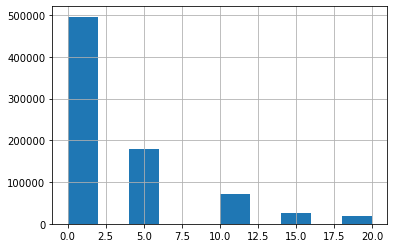

In [9]:
# Checking the Amount distribution
df.Amount.hist()

#### Split 

In [10]:
# Thinking about how i want to split and wanted to know how many rows I had
df_size = len(df)
df_size

790458

In [11]:
# compute num of rows that are 50% of total rows and assign to variable train_size
train_size = int(df_size * .50)
train_size

395229

In [12]:
# compute num of rows that are 30% of total rows and assign to variable validate_size

validate_size = int(df_size * .3)
validate_size

237137

In [13]:
# make test_size the number of rows remaining (test_size = total # of rows - train_size - validate_size)
test_size = int(df_size - train_size - validate_size)
test_size

158092

#### Qauilty Check

In [27]:
# Making sure the numbers add up to the full Data Frame
len(df) == train_size + validate_size + test_size

True

In [14]:
# compute the row number at which the switch from validate to test happens. 
validate_end_index = train_size + validate_size
validate_end_index

632366

In [22]:
# train is equal to start of index to train_size which is (df_size * .50) 
train = df[: train_size]
train.shape

(395229, 4)

In [23]:
# validate is equal to train_size to end of validate_end_index which is (train_size + validate_size)
validate = df[train_size: validate_end_index]
validate.shape

(237137, 4)

In [24]:
# test is equal to validate_end_index to the end of the index
test = df[validate_end_index : ]
test.shape

(158092, 4)

#### Resampling

# Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:

In [18]:
### Simple Average

In [19]:
### Moving Average

In [20]:
### Holt's Linear Trend Model

In [21]:
### Based on previous year/month/etc., this is up to you.